<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/invid_processing_save_as_tfrec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

The InVid fake video dataset could be obtained from https://zenodo.org/record/1147958#.YI1kN7Uza02


To obtain google api key in order to download the YouTube video metadata via YouTube data api v3, follow this link https://developers.google.com/maps/documentation/javascript/get-api-key


In [1]:
!cd '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection'

In [2]:
!pip install jsonlines

In [3]:
#https://developers.google.com/maps/documentation/javascript/get-api-key
#https://console.cloud.google.com/apis/api/youtube.googleapis.com/overview?project=decisive-octane-311811
#https://console.cloud.google.com/apis/api/youtube.googleapis.com/credentials?project=decisive-octane-311811

api_key = 'you_data_api_key'

#Imports

In [41]:
import os, math
import numpy as np
import pandas as pd
import requests
import shutil
from pathlib import Path
import jsonlines
from urllib.parse import urlparse, parse_qs
import json
import ast
import re

from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API


Tensorflow version 2.4.1


#Load data

In [ ]:
df_fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/fake-video-corpus - fake-videos.tsv", sep='\t')

In [ ]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   InVID_id              117 non-null    object
 1   Link                  117 non-null    object
 2   Title                 117 non-null    object
 3   Type of Manipulation  35 non-null     object
 4   Comments              116 non-null    object
 5   Discussed             103 non-null    object
 6   Appeared              15 non-null     object
 7   Timestamp             31 non-null     object
dtypes: object(8)
memory usage: 7.4+ KB


In [ ]:
df_real = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/fake-video-corpus - real-videos.tsv", sep='\t')

In [ ]:
df_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InVID_id          110 non-null    object
 1   Link              110 non-null    object
 2   Title             110 non-null    object
 3   Comments          5 non-null      object
 4   Channel           110 non-null    object
 5   Official channel  47 non-null     object
 6   Subscriptions     110 non-null    object
 7   Description       61 non-null     object
dtypes: object(8)
memory usage: 7.0+ KB


In [ ]:
df_real.sample(1)

,InVID_id,Link,Title,Comments,Channel,Official channel,Subscriptions,Description
90,fvc_r-91,https://www.youtube.com/watch?v=AovFfdcy28E,Sydney hail storm - golf balls falling from th...,NaN,Pete Malicki,NaN,202,NaN


In [ ]:
df_fake.sample(1)

,InVID_id,Link,Title,Type of Manipulation,Comments,Discussed,Appeared,Timestamp
97,fvc-98,https://www.youtube.com/watch?v=LHBmD7go8No,We're taking fashion next level... a dress tha...,Tampering,The viral experiment of woolshed company,http://www.thewoolshedcompany.com/viral.html,NaN,32-end


In [ ]:
df_fake.to_csv('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/invid_fake.csv')
df_real.to_csv('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/invid_real.csv')

#Download Metdata using youtube data api

In [ ]:
fakes = np.array(df_fake.Link)
reals = np.array(df_real.Link)
len(fakes), len(reals)

(117, 110)

In [ ]:
invid_data_fake = Path('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/invid_fake_metdata.json')
invid_data_real = Path('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/invid_real_metadata.json')

invid_data_fake.touch(exist_ok=True)
invid_data_real.touch(exist_ok=True)

In [ ]:
def extract_video_metadata(urls):
  metadata_list=[]
  for url in urls:
    url_data = urlparse(url)
    query = parse_qs(url_data.query)
    video_id = query["v"][0]
    youtube_api_url = f'https://www.googleapis.com/youtube/v3/videos?part=snippet&id={video_id}&key={api_key}'
    r = requests.get(youtube_api_url, stream = True)      
    if r.status_code == 200:
       r.raw.decode_content = True
       data = r.json()
       if len(data['items'])>0:
         metadata_list.append(json.dumps(r.json(), ensure_ascii=False))
  return np.array(metadata_list)


In [ ]:
fake_videos_metadata = extract_video_metadata(fakes)
real_videos_metadata = extract_video_metadata(reals)
fake_videos_metadata.shape, real_videos_metadata.shape

((95,), (71,))

In [ ]:
def write_json_data(path, data):
    with open(path,'w') as f:
        f.writelines("%s\n" % line for line in data)


In [ ]:
write_json_data(invid_data_fake, fake_videos_metadata)
write_json_data(invid_data_real, real_videos_metadata)

#Convert metadata to csv

In [ ]:
fake_data_dict_array = []
real_data_dict_array = []
with jsonlines.open(invid_data_fake) as reader:
    for obj in reader:
      fake_data_dict_array.append(obj)

with jsonlines.open(invid_data_real) as reader:
    for obj in reader:
      real_data_dict_array.append(obj)

len(real_data_dict_array), len(fake_data_dict_array)

(71, 95)

In [ ]:
df_real_metadata = pd.DataFrame.from_dict(real_data_dict_array)
df_real_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   kind      71 non-null     object
 1   etag      71 non-null     object
 2   items     71 non-null     object
 3   pageInfo  71 non-null     object
dtypes: object(4)
memory usage: 2.3+ KB


In [ ]:
df_real_metadata['is_clickbait'] = 0

In [ ]:
df_fake_metadata = pd.DataFrame.from_dict(fake_data_dict_array)
df_fake_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   kind      95 non-null     object
 1   etag      95 non-null     object
 2   items     95 non-null     object
 3   pageInfo  95 non-null     object
dtypes: object(4)
memory usage: 3.1+ KB


In [ ]:
df_fake_metadata['is_clickbait'] = 1

In [ ]:
df_combined = pd.concat([df_real_metadata, df_fake_metadata], ignore_index=True)
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   kind          166 non-null    object
 1   etag          166 non-null    object
 2   items         166 non-null    object
 3   pageInfo      166 non-null    object
 4   is_clickbait  166 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 6.6+ KB


In [ ]:
df_combined = df_combined.sample(frac=1)

In [ ]:
df_combined.to_csv('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/invid_fake_real_combined_metadata.csv', index=False)

#Pre Processing Metadata

In [ ]:
df =  pd.read_csv("/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/invid_fake_real_combined_metadata.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   kind          166 non-null    object
 1   etag          166 non-null    object
 2   items         166 non-null    object
 3   pageInfo      166 non-null    object
 4   is_clickbait  166 non-null    int64 
dtypes: int64(1), object(4)
memory usage: 6.6+ KB


In [ ]:
df_filtered = df.loc[:,['items','is_clickbait']]
df_filtered.head()

,items,is_clickbait
0,"[{'kind': 'youtube#video', 'etag': 'h2W9Yr_4Hd...",1
1,"[{'kind': 'youtube#video', 'etag': 'F1LzpIKFun...",1
2,"[{'kind': 'youtube#video', 'etag': 'NpFa-ESRC0...",1
3,"[{'kind': 'youtube#video', 'etag': 'BJJ9kbS9hd...",1
4,"[{'kind': 'youtube#video', 'etag': '9vzyE36zjz...",1


In [ ]:
def preprocess_string(text):
    text_cleaned = re.sub(r"http\S+", "", text, flags=re.IGNORECASE|re.MULTILINE)  # remove any url in the text
    text_cleaned = re.sub(r"\w+@\w{1,}\.\w{1,}","", text_cleaned, flags=re.IGNORECASE|re.MULTILINE) # remove emails from text
    text_cleaned = re.sub(r'[^a-z\s]+',' ',text_cleaned,flags=re.IGNORECASE|re.MULTILINE) # remove non alphabetics char
    text_cleaned = re.sub(r'(\s+)',' ',text_cleaned, flags=re.IGNORECASE|re.MULTILINE)  # remove spaces

    text_cleaned = text_cleaned.lstrip()
    text_cleaned = text_cleaned.rstrip()
    text_cleaned = text_cleaned.lower() 

    return text_cleaned 

def extract_list_data(row, column_name, sub_column='', clean_text=True):
  row = ast.literal_eval(row)
  items = row[0]
  if len(sub_column)>0:
    if sub_column in items[column_name]:
      text = items[column_name][sub_column]
    else:
      text='NA'
  else:
    text = items[column_name]
  
  if clean_text:
      text = preprocess_string(text)

  return text

def extract_from_dict(row, column, subcolumn):
  return row[column][subcolumn]

  

In [ ]:
df_filtered['id'] = df_filtered.loc[:,'items'].apply(lambda x : extract_list_data(x,'id', clean_text=False))

In [ ]:
df_filtered['title'] = df_filtered.loc[:,'items'].apply(lambda x : extract_list_data(x,'snippet','title'))

In [ ]:
df_filtered['description'] = df_filtered.loc[:,'items'].apply(lambda x : extract_list_data(x,'snippet','description'))

In [ ]:
df_filtered['tags'] = df_filtered.loc[:,'items'].apply(lambda x : extract_list_data(x,'snippet','tags', clean_text=False))

In [ ]:
df_filtered['thumbnails'] = df_filtered.loc[:,'items'].apply(lambda x : extract_list_data(x,'snippet','thumbnails', clean_text=False))

In [ ]:
df_filtered['thumbnail_320_180'] = df_filtered.loc[:,'thumbnails'].apply(lambda x : extract_from_dict(x,'medium','url'))

In [ ]:
df_filtered = df_filtered.drop(['items'], axis=1)

In [ ]:
 df_filtered.loc[(df_filtered.title == ''),'title'] = 'NA'

In [ ]:
 df_filtered.loc[(df_filtered.description == ''), 'description'] = 'NA'

In [ ]:
df_filtered = df_filtered.loc[~((df_filtered.description == 'NA') & (df_filtered.title == 'NA'))]

In [ ]:
df_filtered.head()

,is_clickbait,id,title,description,tags,thumbnails,thumbnail_320_180
0,1,k6PxMRUgmbA,celebrity impressions original song rob cantor,edit full credits listed below for more inform...,"[Rob Cantor, Rob, Cantor, Impressions, Tally H...",{'default': {'url': 'https://i.ytimg.com/vi/k6...,https://i.ytimg.com/vi/k6PxMRUgmbA/mqdefault.jpg
1,1,P7aRR86VfTY,crazy guy runs into outback tornado to take se...,since posting the shark vid i ve been getting ...,"[Tornado, Selfie, Australia, Storm, Into the s...",{'default': {'url': 'https://i.ytimg.com/vi/P7...,https://i.ytimg.com/vi/P7aRR86VfTY/mqdefault.jpg
2,1,GtrBZJ9pYC0,pauly shore punched,pauly shore meets one of his hick fans,"[pauly, shore, punch]",{'default': {'url': 'https://i.ytimg.com/vi/Gt...,https://i.ytimg.com/vi/GtrBZJ9pYC0/mqdefault.jpg
3,1,0QwRW148Jys,hawk throws snake at family eating lunch in me...,NA,NA,{'default': {'url': 'https://i.ytimg.com/vi/0Q...,https://i.ytimg.com/vi/0QwRW148Jys/mqdefault.jpg
4,1,W8SK0rk5jdE,ultimate batting practice,dude smashes pitchbacks like a video game,"[ultimate, batting, practice, pitch, play, bac...",{'default': {'url': 'https://i.ytimg.com/vi/W8...,https://i.ytimg.com/vi/W8SK0rk5jdE/mqdefault.jpg


In [ ]:
df_filtered.to_csv("/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/invid_fake_real_combined_metadata_processed.csv", index=False)

In [ ]:
df_filtered.loc[df_filtered.description == 'NA'].shape

(8, 7)

#Download and map thumbnails

In [ ]:
df_filtered =  pd.read_csv("/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/invid_fake_real_combined_metadata_processed.csv")


In [ ]:
clickbaitImage_dir = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/thumbnails/clickbaits'
nonclickbaitsImage_dir = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/thumbnails/nonclickbaits'

if not os.path.exists(clickbaitImage_dir):
    os.makedirs(clickbaitImage_dir)

if not os.path.exists(nonclickbaitsImage_dir):
    os.makedirs(nonclickbaitsImage_dir)

In [ ]:
def download_save_image(df):
  df_new = df.copy(deep=True)

  for i in range(len(df_new)):
    row = df_new.iloc[i]

    id = row['id']  
    url = row['thumbnail_320_180'] 
    is_clickbait = row['is_clickbait'] 


    filename = f'{id}' + '_' + url.split("/")[-1]      

    if is_clickbait:      
        image_path = os.path.join(clickbaitImage_dir,filename) 
    else:
        image_path = os.path.join(nonclickbaitsImage_dir,filename) 

     
    if not os.path.exists(image_path):                       
            r = requests.get(url, stream = True)             
            
            if r.status_code == 200:                         
                r.raw.decode_content = True

                with open(image_path,'wb') as f:
                    shutil.copyfileobj(r.raw, f)             

                print(i, ': success')

                df_new.loc[(df_new['id'] == id), 'thumbnail_320_180_img'] = image_path        # replace url with image path  

            else:
                print(i, ': failed')

                df_new.loc[(df_new['id'] == id), 'thumbnail_320_180_img'] = 'NA'                 # replace url with empty string 

    else:
        df_new.loc[(df_new['id'] == id), 'thumbnail_320_180_img'] = image_path 
        print('file exist', image_path)

  return df_new 


def update_dataframe(df_p, df_c, index_col='id'):
  df_1 = df_p.copy()
  df_2 = df_c.copy()
  df_1.set_index(index_col, inplace=True)
  df_1.update(df_2.set_index(index_col))
  df_1 = df_1.reset_index() 
  return df_1

In [ ]:
df_filtered = download_save_image(df_filtered)

file exist /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/thumbnails/clickbaits/k6PxMRUgmbA_mqdefault.jpg
file exist /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/thumbnails/clickbaits/P7aRR86VfTY_mqdefault.jpg
file exist /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/thumbnails/clickbaits/GtrBZJ9pYC0_mqdefault.jpg
file exist /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/thumbnails/clickbaits/0QwRW148Jys_mqdefault.jpg
file exist /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/thumbnails/clickbaits/W8SK0rk5jdE_mqdefault.jpg
file exist /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/thumbnails/clickbaits/vT_PNKg3v7s_mqdefault.jpg
file exist /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/thumbnails/nonclickbaits/R

In [ ]:
df_filtered.loc[df_filtered.description.isnull()].shape

(8, 8)

In [ ]:
#df_filtered = df_filtered.loc[~((df_filtered.title.isnull()) | (df_filtered.description.isnull()))]

In [ ]:
df_filtered.shape

(163, 8)

In [ ]:
df_filtered.to_csv("/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/invid_fake_real_combined_metadata_with_image_path.csv", index=False)

#Process data

In [5]:
df_filtered =  pd.read_csv("/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/invid_fake_real_combined_metadata_with_image_path.csv")

In [6]:
df_filtered = df_filtered.drop(['id','tags','thumbnails','thumbnail_320_180'],axis=1)

In [7]:
df_filtered = df_filtered.fillna('NA')

In [8]:
def get_combined_text(row):
  if row['title'] != 'NA' and row['description'] !='NA' :
    return row['title']+' '+row['description']
  elif row['title'] != 'NA':
    return row['title']
  else:
    return row['description']

In [9]:
df_filtered['text'] = df_filtered.apply(lambda x: get_combined_text(x), axis=1)

In [10]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   is_clickbait           163 non-null    int64 
 1   title                  163 non-null    object
 2   description            163 non-null    object
 3   thumbnail_320_180_img  163 non-null    object
 4   text                   163 non-null    object
dtypes: int64(1), object(4)
memory usage: 6.5+ KB


In [11]:
df_filtered = df_filtered.drop(['title','description'], axis=1)

In [24]:
df_filtered.is_clickbait.value_counts()

1    94
0    69
Name: is_clickbait, dtype: int64

In [21]:
#Shuffle data
df_filtered = df_filtered.sample(frac=1).reset_index(drop=True)

#Save data as tfrec

##Create tensorflow dataset from csv file

In [33]:
#@title "Utilities [RUN ME]"
def parse_function(image_path, text, label):
    image_string = tf.io.read_file(image_path)

    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)
    
    return image, text, label

def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(CLASSES[label.numpy()], fontsize=16)
    subplot += 1
    if i==8:
      break
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

In [27]:
df_filtered.shape, df_filtered.columns

((163, 3),
 Index(['is_clickbait', 'thumbnail_320_180_img', 'text'], dtype='object'))

In [26]:
CLASSES = [b'nonclickbaits', b'clickbaits'] 
SHARDS = 4
TARGET_SIZE = [180, 180]

In [ ]:
Y = df_filtered.pop('is_clickbait')
X_IMAGE = df_filtered['thumbnail_320_180_img']
X_TEXT = df_filtered['text']

In [31]:
Y = np.array(Y)
X_IMAGE = np.array(X_IMAGE)
X_TEXT = np.array(X_TEXT)
Y.shape, X_IMAGE.shape, X_TEXT.shape

((163,), (163,), (163,))

In [34]:
dataset = tf.data.Dataset.from_tensor_slices((X_IMAGE, X_TEXT, Y))
dataset1 = dataset.map(parse_function, num_parallel_calls=AUTO)

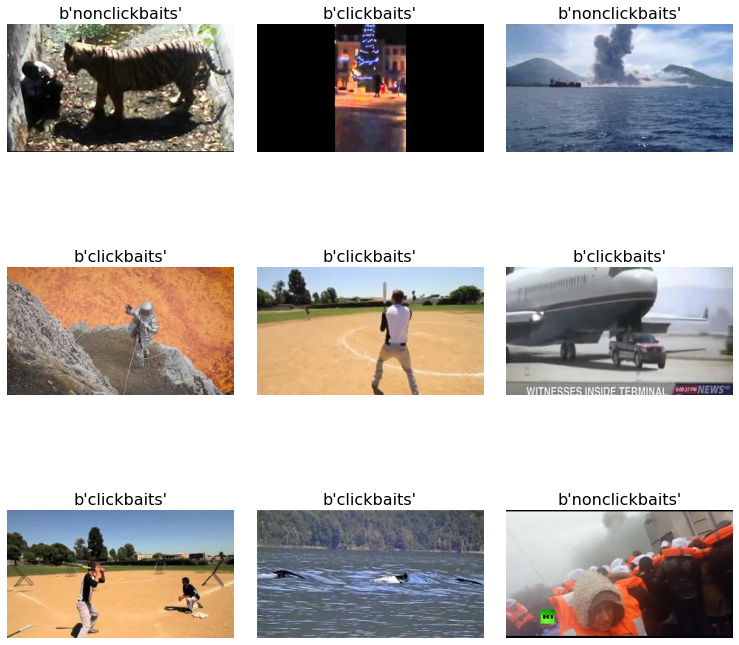

In [36]:
display_dataset = dataset1.map(lambda image,text, class_num: (image, class_num))
display_9_images_from_dataset(display_dataset)

##Resize and crop images to common size

In [37]:
def resize_and_crop_image(image, text, label):
  # Resize and crop using "fill" algorithm:
  # always make sure the resulting image
  # is cut out from the source image so that
  # it fills the TARGET_SIZE entirely with no
  # black bars and a preserved aspect ratio.
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, text, label
  
dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=AUTO) 

In [38]:
for image, text, label in dataset2.take(10):
  print(image.numpy().shape, CLASSES[label.numpy()])

(180, 180, 3) b'nonclickbaits'
(180, 180, 3) b'clickbaits'
(180, 180, 3) b'nonclickbaits'
(180, 180, 3) b'clickbaits'
(180, 180, 3) b'clickbaits'
(180, 180, 3) b'clickbaits'
(180, 180, 3) b'clickbaits'
(180, 180, 3) b'clickbaits'
(180, 180, 3) b'nonclickbaits'
(180, 180, 3) b'clickbaits'


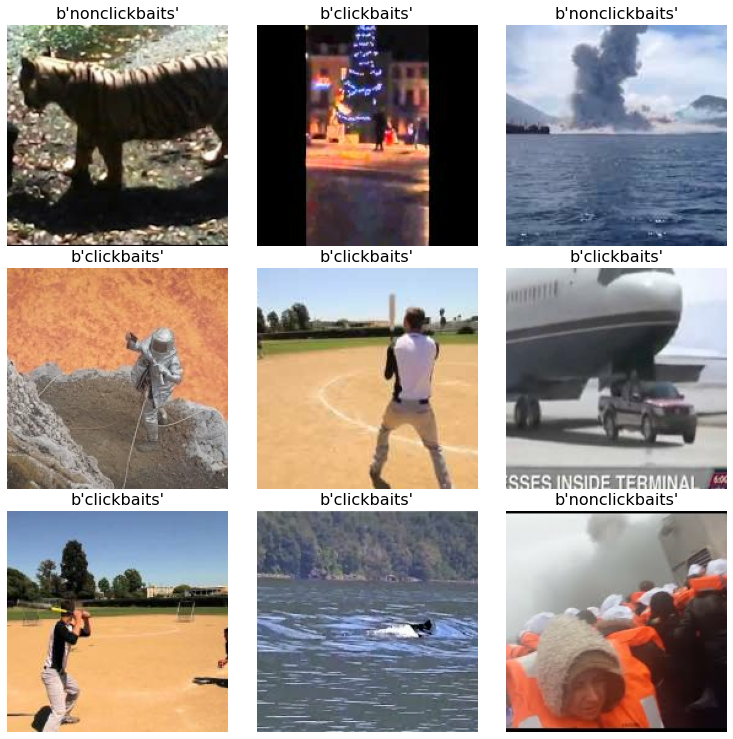

In [39]:
display_dataset = dataset2.map(lambda image,text, class_num: (image, class_num))
display_9_images_from_dataset(display_dataset)

##Recompress the images

In [47]:
#@title "Run Me"
def recompress_image(image,text, label):
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, text, label, height, width

In [48]:
nb_images = len(dataset2)
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

Pattern matches 163 images which will be rewritten as 4 .tfrec files containing 41 images each.


In [49]:
dataset3 = dataset2.map(recompress_image, num_parallel_calls=AUTO)
dataset3 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 

##Write dataset to TFRecord files

In [54]:
#@title "Run Me"
# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, img_bytes, text, label, height, width):  
  class_num = label 

  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]),        # one class in the list
      "text":  _bytestring_feature([text]),       # text feature   
      "label":         _bytestring_feature([CLASSES[label]]),          # fixed length (1) list of strings, the text label
      "size":          _int_feature([height, width]),         # fixed length (2) list of ints
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  


In [55]:
tfrec_root = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/tfrec_data'
PATH_OUTPUT = os.path.join(tfrec_root,'image_text')
PATH_OUTPUT

'/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/tfrec_data/image_text'

In [56]:
if not os.path.exists(tfrec_root):
  os.mkdir(tfrec_root)

In [57]:
print("Writing TFRecords")
for shard, (image, text, label, height, width) in enumerate(dataset3):
  # batch size used as shard size here
  shard_size = image.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = PATH_OUTPUT + "{:02d}-{}.tfrec".format(shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            image.numpy()[i], # re-compressed image: already a byte string
                            text.numpy()[i],
                            label.numpy()[i],
                            height.numpy()[i],
                            width.numpy()[i])
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/tfrec_data/image_text00-41.tfrec containing 41 records
Wrote file /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/tfrec_data/image_text01-41.tfrec containing 41 records
Wrote file /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/tfrec_data/image_text02-41.tfrec containing 41 records
Wrote file /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/tfrec_data/image_text03-40.tfrec containing 40 records


##Read from TFRecord Dataset

In [58]:
#@title "Run Me"
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        "text": tf.io.FixedLenFeature([], tf.string),
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64)  # two integers
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    text = example['text']
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    return image, text, class_num, label, height, width


In [59]:
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob(PATH_OUTPUT + "*.tfrec")
len(filenames)

4

In [60]:
dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
dataset4 = dataset4.with_options(option_no_order)
dataset4 = dataset4.map(read_tfrecord, num_parallel_calls=AUTO)
dataset4 = dataset4.shuffle(300)

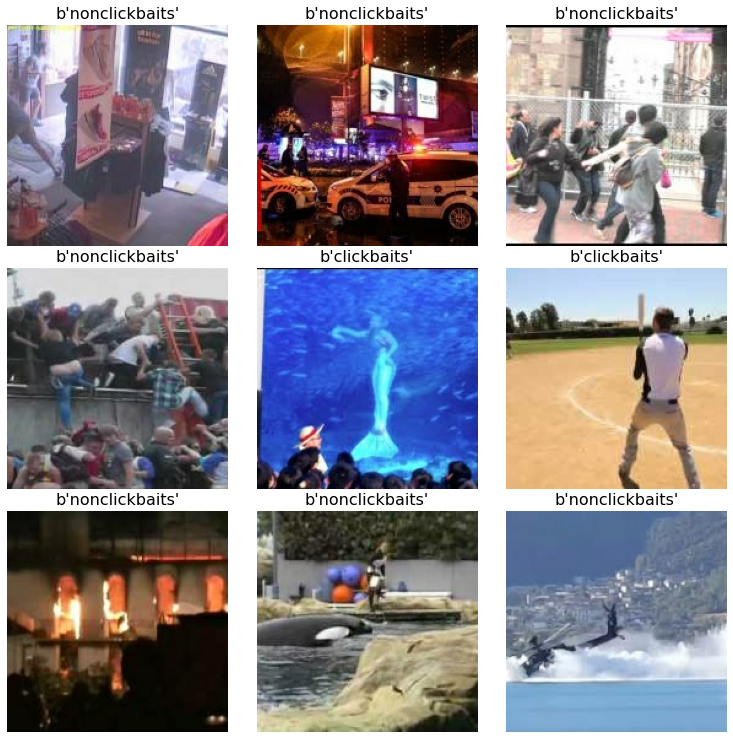

In [61]:
display_dataset = dataset4.map(lambda image,text, class_num, label, height, width: (image, class_num))
display_9_images_from_dataset(display_dataset)